# Solution for a disk with Dirichlet boundary conditions

The solution for

$$\nabla^2 u(r, \theta) = \quad 0 < r < 1\, $$

with $u(1, \theta) = g(\theta)\quad 0 \leq \theta \leq 2\pi$, is given by

$$u(r, \theta) = \frac{1}{2\pi}\int\limits_0^{2\pi}
\left[\frac{1 - r^2}{1 - 2r\cos(\theta - \phi) + r^2}\right]
g(\phi) \rho d\rho d\phi\, .$$    

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log, arctan2, pi, sqrt, cos
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
import meshio

In [3]:
mesh = meshio.read("files/disk.msh")
pts = mesh.points
lines = np.vstack([cells.data for cells in mesh.cells[0:4]])
tris = mesh.cells[-1].data
x, y, _ = pts.T

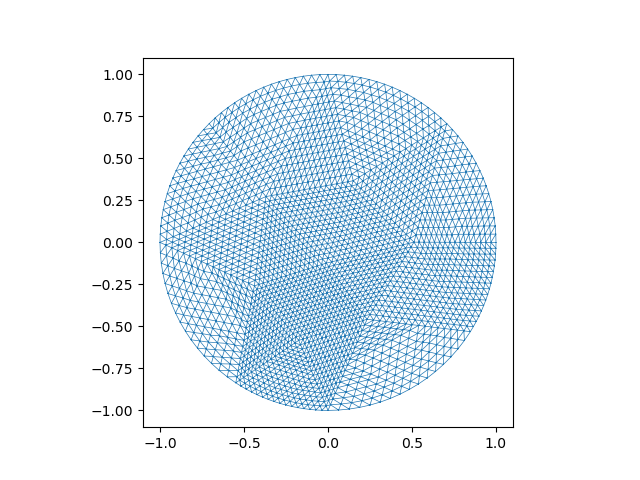

In [4]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5)
plt.axis("image");

In [5]:
def green_fun_grad(phi, r, theta):
    """
    Green function for Poisson equation in a circular domain
    
    Parameters
    ----------
    phi : float
        Azimuthal coordinate for the loading point.
    r : float
        Radial coordinate for the observation point.
    theta : float
        Azimuthal coordinate for the observation point.

    Returns
    -------
    phi : float
        Value of the potential at (r, theta).
    """
    cos_d = cos(theta) * cos(phi) + np.sin(theta)*np.sin(phi)
    return 0.5/pi * (1 - r**2)/(1 - 2*r*cos_d + r**2)

In [6]:
def length_line(coords):
    """Compute length and norma a line with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the line.

    Returns
    -------
    area : float
        Area of the triangle
    """
    vec = coords[1, :] - coords[0, :]
    L = np.linalg.norm(vec)
    return L

In [7]:
def eval_bound(eval_pts, pts, lines, boundary):
    """
    Evaluate the solution inside the disk for
    a given Dirichlet boundary condition

    Parameters
    ----------
    eval_pts : ndarray, float
        Coordinates for the nodes of evaluation.
    pts : ndarray, float
        Coordinates for the nodes of the triangle.
    lines : ndarray, int
        Connectivity for the lines.
    boundary : callable
        Dirichlet boundary condition.

    Returns
    -------
    potential : ndarray, float
        Potential evaluated at each observation point.
    """
    potential = np.zeros_like(eval_pts[:, 0])
    for line in lines:
        coords = pts[line]
        L = length_line(coords)
        xm, ym, _ = np.mean(coords, axis=0)
        phi = np.arctan2(ym, xm)
        g = boundary(phi)
        for cont, pt in enumerate(eval_pts):
            pt_x, pt_y, _ = pt
            r = np.sqrt(pt_x**2 + pt_y**2)
            theta = np.arctan2(pt_y, pt_x)
            if np.isclose(r, 1):
                potential[cont] = boundary(theta)
            else:
                pot = green_fun_grad(phi, r, theta)
                potential[cont] += L * pot * g
    return potential

## Example: constant value

In this case we have the problem

$$\nabla^2 u(r, \theta) = 0\quad 0 < r < 1\, $$

with $u(1, \theta) = 1$.


The analytical solution in this case is given by


$$u(r) = 1\, .$$

In [8]:
boundary = lambda phi: 1
potential = eval_bound(pts, pts, lines, boundary)

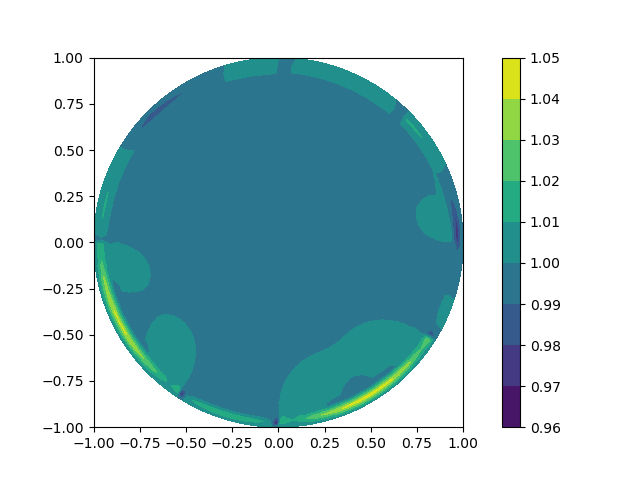

In [9]:
plt.figure()
plt.tricontourf(x, y, tris, potential )
plt.colorbar()
plt.axis("image");

## Example with angular variation

In this case we have the problem

$$\nabla^2 u(x, y) = 0
\quad 0 < x^2 + y^2 < 1\, $$

with $u(\theta) = \cos(6\theta)$ at $x^2 +y^2 = 1$.


The analytical solution in this case is given by


$$u(x, y) = r^6 \cos(6\theta)\, .$$

In [10]:
boundary = lambda theta: cos(6*theta)
potential = eval_bound(pts, pts, lines, boundary)

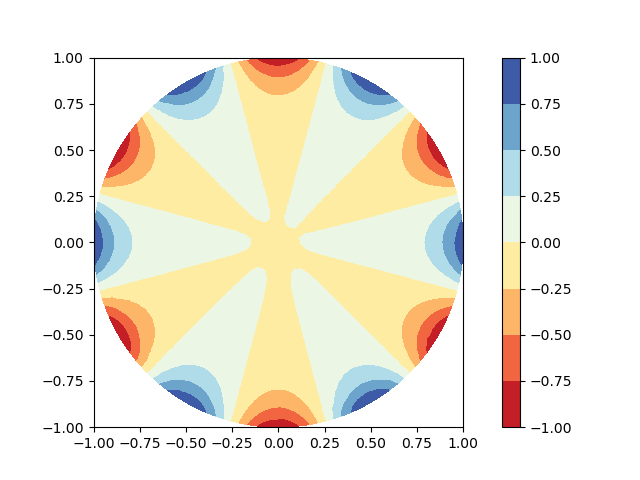

In [11]:
plt.figure()
plt.tricontourf(x, y, tris, potential, cmap="RdYlBu")
plt.colorbar()
plt.axis("image");

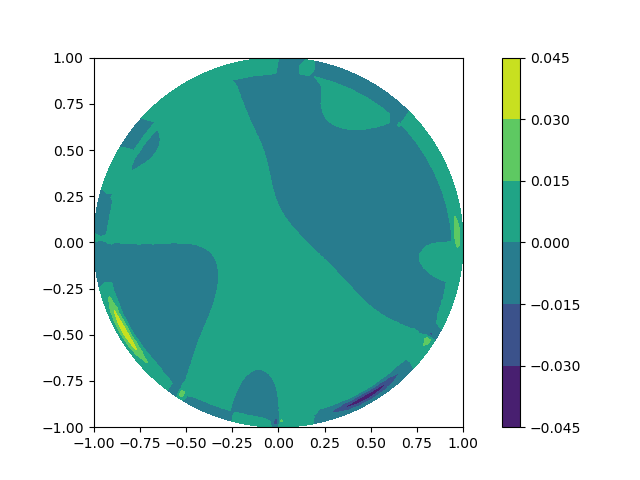

In [12]:
plt.figure()
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
plt.tricontourf(x, y, tris, r**6 * np.cos(6*theta) - potential)
plt.colorbar()
plt.axis("image");